<h1>Simple LSTM with Monthly Dataset</h1>

In [1]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')

In [186]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [187]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/data.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [188]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [189]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [190]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [191]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [192]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
#     print('max val king_train:')
    print(max(king_training['king']))
    king_test[king_test["king"] < 0] = 0
#     print('max val king_test:')
    print(max(king_test['king']))
    king_train_pre = king_training["king"].to_frame()
#     print(king_train_norm)
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)
    print('king_test_norm')
    print(king_test_norm.shape)
    print('king_train_norm')
    print(king_train_norm.shape)
    #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
    #print(type(king_train_norm))
    #king_train_norm = king_train_norm.to_frame()
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    # Todo: Experiment with input size of input (ex. 30 days)
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [193]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)

(60, 2)
717915
294611
king_test_norm
(60, 1)
king_train_norm
(924, 1)
(54, 1)
(54, 1)
(918, 1)
(918, 1)


In [194]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [195]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=3000, batch_size=300, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [196]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/3000
4/4 - 1s - loss: 0.0102
Epoch 2/3000
4/4 - 0s - loss: 0.0098
Epoch 3/3000
4/4 - 0s - loss: 0.0097
Epoch 4/3000
4/4 - 0s - loss: 0.0097
Epoch 5/3000
4/4 - 0s - loss: 0.0096
Epoch 6/3000
4/4 - 0s - loss: 0.0096
Epoch 7/3000
4/4 - 0s - loss: 0.0096
Epoch 8/3000
4/4 - 0s - loss: 0.0095
Epoch 9/3000
4/4 - 0s - loss: 0.0095
Epoch 10/3000
4/4 - 0s - loss: 0.0095
Epoch 11/3000
4/4 - 0s - loss: 0.0095
Epoch 12/3000
4/4 - 0s - loss: 0.0095
Epoch 13/3000
4/4 - 0s - loss: 0.0094
Epoch 14/3000
4/4 - 0s - loss: 0.0094
Epoch 15/3000
4/4 - 0s - loss: 0.0094
Epoch 16/3000
4/4 - 0s - loss: 0.0094
Epoch 17/3000
4/4 - 0s - loss: 0.0094
Epoch 18/3000
4/4 - 0s - loss: 0.0094
Epoch 19/3000
4/4 - 0s - loss: 0.0093
Epoch 20/3000
4/4 - 0s - loss: 0.0093
Epoch 21/3000
4/4 - 0s - loss: 0.0093
Epoch 22/3000
4/4 - 0s - loss: 0.0093
Epoch 23/3000
4/4 - 0s - loss: 0.0093
Epoch 24/3000
4/4 - 0s - loss: 0.0093
Epoch 25/3000
4/4 - 0s - loss: 0.0093
Epoch 26/3000
4/4 - 0s - loss: 0.0092
Epoch 27/3000
4/4 - 0

Epoch 214/3000
4/4 - 0s - loss: 0.0087
Epoch 215/3000
4/4 - 0s - loss: 0.0087
Epoch 216/3000
4/4 - 0s - loss: 0.0087
Epoch 217/3000
4/4 - 0s - loss: 0.0087
Epoch 218/3000
4/4 - 0s - loss: 0.0087
Epoch 219/3000
4/4 - 0s - loss: 0.0087
Epoch 220/3000
4/4 - 0s - loss: 0.0087
Epoch 221/3000
4/4 - 0s - loss: 0.0087
Epoch 222/3000
4/4 - 0s - loss: 0.0087
Epoch 223/3000
4/4 - 0s - loss: 0.0087
Epoch 224/3000
4/4 - 0s - loss: 0.0087
Epoch 225/3000
4/4 - 0s - loss: 0.0087
Epoch 226/3000
4/4 - 0s - loss: 0.0087
Epoch 227/3000
4/4 - 0s - loss: 0.0087
Epoch 228/3000
4/4 - 0s - loss: 0.0087
Epoch 229/3000
4/4 - 0s - loss: 0.0087
Epoch 230/3000
4/4 - 0s - loss: 0.0087
Epoch 231/3000
4/4 - 0s - loss: 0.0087
Epoch 232/3000
4/4 - 0s - loss: 0.0087
Epoch 233/3000
4/4 - 0s - loss: 0.0087
Epoch 234/3000
4/4 - 0s - loss: 0.0087
Epoch 235/3000
4/4 - 0s - loss: 0.0087
Epoch 236/3000
4/4 - 0s - loss: 0.0087
Epoch 237/3000
4/4 - 0s - loss: 0.0087
Epoch 238/3000
4/4 - 0s - loss: 0.0087
Epoch 239/3000
4/4 - 0s -

4/4 - 0s - loss: 0.0087
Epoch 425/3000
4/4 - 0s - loss: 0.0086
Epoch 426/3000
4/4 - 0s - loss: 0.0086
Epoch 427/3000
4/4 - 0s - loss: 0.0087
Epoch 428/3000
4/4 - 0s - loss: 0.0087
Epoch 429/3000
4/4 - 0s - loss: 0.0087
Epoch 430/3000
4/4 - 0s - loss: 0.0086
Epoch 431/3000
4/4 - 0s - loss: 0.0086
Epoch 432/3000
4/4 - 0s - loss: 0.0087
Epoch 433/3000
4/4 - 0s - loss: 0.0087
Epoch 434/3000
4/4 - 0s - loss: 0.0087
Epoch 435/3000
4/4 - 0s - loss: 0.0086
Epoch 436/3000
4/4 - 0s - loss: 0.0086
Epoch 437/3000
4/4 - 0s - loss: 0.0086
Epoch 438/3000
4/4 - 0s - loss: 0.0086
Epoch 439/3000
4/4 - 0s - loss: 0.0086
Epoch 440/3000
4/4 - 0s - loss: 0.0086
Epoch 441/3000
4/4 - 0s - loss: 0.0087
Epoch 442/3000
4/4 - 0s - loss: 0.0086
Epoch 443/3000
4/4 - 0s - loss: 0.0086
Epoch 444/3000
4/4 - 0s - loss: 0.0086
Epoch 445/3000
4/4 - 0s - loss: 0.0086
Epoch 446/3000
4/4 - 0s - loss: 0.0086
Epoch 447/3000
4/4 - 0s - loss: 0.0086
Epoch 448/3000
4/4 - 0s - loss: 0.0087
Epoch 449/3000
4/4 - 0s - loss: 0.0086
E

Epoch 635/3000
4/4 - 0s - loss: 0.0084
Epoch 636/3000
4/4 - 0s - loss: 0.0084
Epoch 637/3000
4/4 - 0s - loss: 0.0084
Epoch 638/3000
4/4 - 0s - loss: 0.0084
Epoch 639/3000
4/4 - 0s - loss: 0.0086
Epoch 640/3000
4/4 - 0s - loss: 0.0087
Epoch 641/3000
4/4 - 0s - loss: 0.0085
Epoch 642/3000
4/4 - 0s - loss: 0.0084
Epoch 643/3000
4/4 - 0s - loss: 0.0084
Epoch 644/3000
4/4 - 0s - loss: 0.0084
Epoch 645/3000
4/4 - 0s - loss: 0.0084
Epoch 646/3000
4/4 - 0s - loss: 0.0085
Epoch 647/3000
4/4 - 0s - loss: 0.0085
Epoch 648/3000
4/4 - 0s - loss: 0.0084
Epoch 649/3000
4/4 - 0s - loss: 0.0084
Epoch 650/3000
4/4 - 0s - loss: 0.0084
Epoch 651/3000
4/4 - 0s - loss: 0.0084
Epoch 652/3000
4/4 - 0s - loss: 0.0084
Epoch 653/3000
4/4 - 0s - loss: 0.0084
Epoch 654/3000
4/4 - 0s - loss: 0.0084
Epoch 655/3000
4/4 - 0s - loss: 0.0084
Epoch 656/3000
4/4 - 0s - loss: 0.0085
Epoch 657/3000
4/4 - 0s - loss: 0.0084
Epoch 658/3000
4/4 - 0s - loss: 0.0084
Epoch 659/3000
4/4 - 0s - loss: 0.0084
Epoch 660/3000
4/4 - 0s -

4/4 - 0s - loss: 0.0083
Epoch 846/3000
4/4 - 0s - loss: 0.0083
Epoch 847/3000
4/4 - 0s - loss: 0.0083
Epoch 848/3000
4/4 - 0s - loss: 0.0084
Epoch 849/3000
4/4 - 0s - loss: 0.0083
Epoch 850/3000
4/4 - 0s - loss: 0.0082
Epoch 851/3000
4/4 - 0s - loss: 0.0083
Epoch 852/3000
4/4 - 0s - loss: 0.0083
Epoch 853/3000
4/4 - 0s - loss: 0.0082
Epoch 854/3000
4/4 - 0s - loss: 0.0082
Epoch 855/3000
4/4 - 0s - loss: 0.0082
Epoch 856/3000
4/4 - 0s - loss: 0.0083
Epoch 857/3000
4/4 - 0s - loss: 0.0083
Epoch 858/3000
4/4 - 0s - loss: 0.0083
Epoch 859/3000
4/4 - 0s - loss: 0.0083
Epoch 860/3000
4/4 - 0s - loss: 0.0082
Epoch 861/3000
4/4 - 0s - loss: 0.0082
Epoch 862/3000
4/4 - 0s - loss: 0.0083
Epoch 863/3000
4/4 - 0s - loss: 0.0082
Epoch 864/3000
4/4 - 0s - loss: 0.0082
Epoch 865/3000
4/4 - 0s - loss: 0.0082
Epoch 866/3000
4/4 - 0s - loss: 0.0082
Epoch 867/3000
4/4 - 0s - loss: 0.0083
Epoch 868/3000
4/4 - 0s - loss: 0.0083
Epoch 869/3000
4/4 - 0s - loss: 0.0082
Epoch 870/3000
4/4 - 0s - loss: 0.0082
E

4/4 - 0s - loss: 0.0081
Epoch 1055/3000
4/4 - 0s - loss: 0.0081
Epoch 1056/3000
4/4 - 0s - loss: 0.0081
Epoch 1057/3000
4/4 - 0s - loss: 0.0081
Epoch 1058/3000
4/4 - 0s - loss: 0.0081
Epoch 1059/3000
4/4 - 0s - loss: 0.0082
Epoch 1060/3000
4/4 - 0s - loss: 0.0081
Epoch 1061/3000
4/4 - 0s - loss: 0.0081
Epoch 1062/3000
4/4 - 0s - loss: 0.0081
Epoch 1063/3000
4/4 - 0s - loss: 0.0081
Epoch 1064/3000
4/4 - 0s - loss: 0.0081
Epoch 1065/3000
4/4 - 0s - loss: 0.0081
Epoch 1066/3000
4/4 - 0s - loss: 0.0081
Epoch 1067/3000
4/4 - 0s - loss: 0.0082
Epoch 1068/3000
4/4 - 0s - loss: 0.0081
Epoch 1069/3000
4/4 - 0s - loss: 0.0081
Epoch 1070/3000
4/4 - 0s - loss: 0.0081
Epoch 1071/3000
4/4 - 0s - loss: 0.0081
Epoch 1072/3000
4/4 - 0s - loss: 0.0081
Epoch 1073/3000
4/4 - 0s - loss: 0.0081
Epoch 1074/3000
4/4 - 0s - loss: 0.0081
Epoch 1075/3000
4/4 - 0s - loss: 0.0081
Epoch 1076/3000
4/4 - 0s - loss: 0.0081
Epoch 1077/3000
4/4 - 0s - loss: 0.0081
Epoch 1078/3000
4/4 - 0s - loss: 0.0081
Epoch 1079/3000


4/4 - 0s - loss: 0.0078
Epoch 1260/3000
4/4 - 0s - loss: 0.0081
Epoch 1261/3000
4/4 - 0s - loss: 0.0080
Epoch 1262/3000
4/4 - 0s - loss: 0.0078
Epoch 1263/3000
4/4 - 0s - loss: 0.0079
Epoch 1264/3000
4/4 - 0s - loss: 0.0079
Epoch 1265/3000
4/4 - 0s - loss: 0.0078
Epoch 1266/3000
4/4 - 0s - loss: 0.0078
Epoch 1267/3000
4/4 - 0s - loss: 0.0078
Epoch 1268/3000
4/4 - 0s - loss: 0.0078
Epoch 1269/3000
4/4 - 0s - loss: 0.0079
Epoch 1270/3000
4/4 - 0s - loss: 0.0078
Epoch 1271/3000
4/4 - 0s - loss: 0.0078
Epoch 1272/3000
4/4 - 0s - loss: 0.0078
Epoch 1273/3000
4/4 - 0s - loss: 0.0078
Epoch 1274/3000
4/4 - 0s - loss: 0.0078
Epoch 1275/3000
4/4 - 0s - loss: 0.0078
Epoch 1276/3000
4/4 - 0s - loss: 0.0078
Epoch 1277/3000
4/4 - 0s - loss: 0.0078
Epoch 1278/3000
4/4 - 0s - loss: 0.0078
Epoch 1279/3000
4/4 - 0s - loss: 0.0078
Epoch 1280/3000
4/4 - 0s - loss: 0.0078
Epoch 1281/3000
4/4 - 0s - loss: 0.0078
Epoch 1282/3000
4/4 - 0s - loss: 0.0078
Epoch 1283/3000
4/4 - 0s - loss: 0.0078
Epoch 1284/3000


4/4 - 0s - loss: 0.0075
Epoch 1465/3000
4/4 - 0s - loss: 0.0075
Epoch 1466/3000
4/4 - 0s - loss: 0.0075
Epoch 1467/3000
4/4 - 0s - loss: 0.0075
Epoch 1468/3000
4/4 - 0s - loss: 0.0076
Epoch 1469/3000
4/4 - 0s - loss: 0.0075
Epoch 1470/3000
4/4 - 0s - loss: 0.0079
Epoch 1471/3000
4/4 - 0s - loss: 0.0075
Epoch 1472/3000
4/4 - 0s - loss: 0.0080
Epoch 1473/3000
4/4 - 0s - loss: 0.0079
Epoch 1474/3000
4/4 - 0s - loss: 0.0075
Epoch 1475/3000
4/4 - 0s - loss: 0.0077
Epoch 1476/3000
4/4 - 0s - loss: 0.0078
Epoch 1477/3000
4/4 - 0s - loss: 0.0076
Epoch 1478/3000
4/4 - 0s - loss: 0.0078
Epoch 1479/3000
4/4 - 0s - loss: 0.0075
Epoch 1480/3000
4/4 - 0s - loss: 0.0075
Epoch 1481/3000
4/4 - 0s - loss: 0.0075
Epoch 1482/3000
4/4 - 0s - loss: 0.0076
Epoch 1483/3000
4/4 - 0s - loss: 0.0075
Epoch 1484/3000
4/4 - 0s - loss: 0.0075
Epoch 1485/3000
4/4 - 0s - loss: 0.0075
Epoch 1486/3000
4/4 - 0s - loss: 0.0075
Epoch 1487/3000
4/4 - 0s - loss: 0.0075
Epoch 1488/3000
4/4 - 0s - loss: 0.0075
Epoch 1489/3000


4/4 - 0s - loss: 0.0077
Epoch 1670/3000
4/4 - 0s - loss: 0.0077
Epoch 1671/3000
4/4 - 0s - loss: 0.0074
Epoch 1672/3000
4/4 - 0s - loss: 0.0073
Epoch 1673/3000
4/4 - 0s - loss: 0.0074
Epoch 1674/3000
4/4 - 0s - loss: 0.0073
Epoch 1675/3000
4/4 - 0s - loss: 0.0072
Epoch 1676/3000
4/4 - 0s - loss: 0.0072
Epoch 1677/3000
4/4 - 0s - loss: 0.0072
Epoch 1678/3000
4/4 - 0s - loss: 0.0072
Epoch 1679/3000
4/4 - 0s - loss: 0.0072
Epoch 1680/3000
4/4 - 0s - loss: 0.0073
Epoch 1681/3000
4/4 - 0s - loss: 0.0072
Epoch 1682/3000
4/4 - 0s - loss: 0.0073
Epoch 1683/3000
4/4 - 0s - loss: 0.0074
Epoch 1684/3000
4/4 - 0s - loss: 0.0073
Epoch 1685/3000
4/4 - 0s - loss: 0.0072
Epoch 1686/3000
4/4 - 0s - loss: 0.0072
Epoch 1687/3000
4/4 - 0s - loss: 0.0072
Epoch 1688/3000
4/4 - 0s - loss: 0.0073
Epoch 1689/3000
4/4 - 0s - loss: 0.0072
Epoch 1690/3000
4/4 - 0s - loss: 0.0072
Epoch 1691/3000
4/4 - 0s - loss: 0.0072
Epoch 1692/3000
4/4 - 0s - loss: 0.0073
Epoch 1693/3000
4/4 - 0s - loss: 0.0073
Epoch 1694/3000


4/4 - 0s - loss: 0.0070
Epoch 1875/3000
4/4 - 0s - loss: 0.0070
Epoch 1876/3000
4/4 - 0s - loss: 0.0070
Epoch 1877/3000
4/4 - 0s - loss: 0.0072
Epoch 1878/3000
4/4 - 0s - loss: 0.0074
Epoch 1879/3000
4/4 - 0s - loss: 0.0070
Epoch 1880/3000
4/4 - 0s - loss: 0.0073
Epoch 1881/3000
4/4 - 0s - loss: 0.0070
Epoch 1882/3000
4/4 - 0s - loss: 0.0072
Epoch 1883/3000
4/4 - 0s - loss: 0.0072
Epoch 1884/3000
4/4 - 0s - loss: 0.0071
Epoch 1885/3000
4/4 - 0s - loss: 0.0072
Epoch 1886/3000
4/4 - 0s - loss: 0.0072
Epoch 1887/3000
4/4 - 0s - loss: 0.0073
Epoch 1888/3000
4/4 - 0s - loss: 0.0071
Epoch 1889/3000
4/4 - 0s - loss: 0.0072
Epoch 1890/3000
4/4 - 0s - loss: 0.0070
Epoch 1891/3000
4/4 - 0s - loss: 0.0071
Epoch 1892/3000
4/4 - 0s - loss: 0.0070
Epoch 1893/3000
4/4 - 0s - loss: 0.0071
Epoch 1894/3000
4/4 - 0s - loss: 0.0070
Epoch 1895/3000
4/4 - 0s - loss: 0.0070
Epoch 1896/3000
4/4 - 0s - loss: 0.0070
Epoch 1897/3000
4/4 - 0s - loss: 0.0070
Epoch 1898/3000
4/4 - 0s - loss: 0.0070
Epoch 1899/3000


4/4 - 0s - loss: 0.0069
Epoch 2080/3000
4/4 - 0s - loss: 0.0073
Epoch 2081/3000
4/4 - 0s - loss: 0.0076
Epoch 2082/3000
4/4 - 0s - loss: 0.0068
Epoch 2083/3000
4/4 - 0s - loss: 0.0072
Epoch 2084/3000
4/4 - 0s - loss: 0.0068
Epoch 2085/3000
4/4 - 0s - loss: 0.0071
Epoch 2086/3000
4/4 - 0s - loss: 0.0069
Epoch 2087/3000
4/4 - 0s - loss: 0.0068
Epoch 2088/3000
4/4 - 0s - loss: 0.0070
Epoch 2089/3000
4/4 - 0s - loss: 0.0068
Epoch 2090/3000
4/4 - 0s - loss: 0.0068
Epoch 2091/3000
4/4 - 0s - loss: 0.0068
Epoch 2092/3000
4/4 - 0s - loss: 0.0069
Epoch 2093/3000
4/4 - 0s - loss: 0.0068
Epoch 2094/3000
4/4 - 0s - loss: 0.0068
Epoch 2095/3000
4/4 - 0s - loss: 0.0067
Epoch 2096/3000
4/4 - 0s - loss: 0.0067
Epoch 2097/3000
4/4 - 0s - loss: 0.0067
Epoch 2098/3000
4/4 - 0s - loss: 0.0068
Epoch 2099/3000
4/4 - 0s - loss: 0.0068
Epoch 2100/3000
4/4 - 0s - loss: 0.0068
Epoch 2101/3000
4/4 - 0s - loss: 0.0067
Epoch 2102/3000
4/4 - 0s - loss: 0.0067
Epoch 2103/3000
4/4 - 0s - loss: 0.0068
Epoch 2104/3000


4/4 - 0s - loss: 0.0066
Epoch 2285/3000
4/4 - 0s - loss: 0.0066
Epoch 2286/3000
4/4 - 0s - loss: 0.0065
Epoch 2287/3000
4/4 - 0s - loss: 0.0065
Epoch 2288/3000
4/4 - 0s - loss: 0.0065
Epoch 2289/3000
4/4 - 0s - loss: 0.0065
Epoch 2290/3000
4/4 - 0s - loss: 0.0065
Epoch 2291/3000
4/4 - 0s - loss: 0.0065
Epoch 2292/3000
4/4 - 0s - loss: 0.0065
Epoch 2293/3000
4/4 - 0s - loss: 0.0065
Epoch 2294/3000
4/4 - 0s - loss: 0.0065
Epoch 2295/3000
4/4 - 0s - loss: 0.0065
Epoch 2296/3000
4/4 - 0s - loss: 0.0064
Epoch 2297/3000
4/4 - 0s - loss: 0.0072
Epoch 2298/3000
4/4 - 0s - loss: 0.0068
Epoch 2299/3000
4/4 - 0s - loss: 0.0066
Epoch 2300/3000
4/4 - 0s - loss: 0.0066
Epoch 2301/3000
4/4 - 0s - loss: 0.0065
Epoch 2302/3000
4/4 - 0s - loss: 0.0066
Epoch 2303/3000
4/4 - 0s - loss: 0.0066
Epoch 2304/3000
4/4 - 0s - loss: 0.0065
Epoch 2305/3000
4/4 - 0s - loss: 0.0067
Epoch 2306/3000
4/4 - 0s - loss: 0.0067
Epoch 2307/3000
4/4 - 0s - loss: 0.0065
Epoch 2308/3000
4/4 - 0s - loss: 0.0065
Epoch 2309/3000


4/4 - 0s - loss: 0.0063
Epoch 2490/3000
4/4 - 0s - loss: 0.0063
Epoch 2491/3000
4/4 - 0s - loss: 0.0062
Epoch 2492/3000
4/4 - 0s - loss: 0.0062
Epoch 2493/3000
4/4 - 0s - loss: 0.0062
Epoch 2494/3000
4/4 - 0s - loss: 0.0063
Epoch 2495/3000
4/4 - 0s - loss: 0.0064
Epoch 2496/3000
4/4 - 0s - loss: 0.0063
Epoch 2497/3000
4/4 - 0s - loss: 0.0064
Epoch 2498/3000
4/4 - 0s - loss: 0.0063
Epoch 2499/3000
4/4 - 0s - loss: 0.0065
Epoch 2500/3000
4/4 - 0s - loss: 0.0063
Epoch 2501/3000
4/4 - 0s - loss: 0.0063
Epoch 2502/3000
4/4 - 0s - loss: 0.0063
Epoch 2503/3000
4/4 - 0s - loss: 0.0062
Epoch 2504/3000
4/4 - 0s - loss: 0.0062
Epoch 2505/3000
4/4 - 0s - loss: 0.0062
Epoch 2506/3000
4/4 - 0s - loss: 0.0062
Epoch 2507/3000
4/4 - 0s - loss: 0.0062
Epoch 2508/3000
4/4 - 0s - loss: 0.0065
Epoch 2509/3000
4/4 - 0s - loss: 0.0065
Epoch 2510/3000
4/4 - 0s - loss: 0.0064
Epoch 2511/3000
4/4 - 0s - loss: 0.0065
Epoch 2512/3000
4/4 - 0s - loss: 0.0063
Epoch 2513/3000
4/4 - 0s - loss: 0.0062
Epoch 2514/3000


4/4 - 0s - loss: 0.0061
Epoch 2695/3000
4/4 - 0s - loss: 0.0060
Epoch 2696/3000
4/4 - 0s - loss: 0.0061
Epoch 2697/3000
4/4 - 0s - loss: 0.0061
Epoch 2698/3000
4/4 - 0s - loss: 0.0061
Epoch 2699/3000
4/4 - 0s - loss: 0.0061
Epoch 2700/3000
4/4 - 0s - loss: 0.0061
Epoch 2701/3000
4/4 - 0s - loss: 0.0061
Epoch 2702/3000
4/4 - 0s - loss: 0.0061
Epoch 2703/3000
4/4 - 0s - loss: 0.0067
Epoch 2704/3000
4/4 - 0s - loss: 0.0060
Epoch 2705/3000
4/4 - 0s - loss: 0.0067
Epoch 2706/3000
4/4 - 0s - loss: 0.0063
Epoch 2707/3000
4/4 - 0s - loss: 0.0063
Epoch 2708/3000
4/4 - 0s - loss: 0.0063
Epoch 2709/3000
4/4 - 0s - loss: 0.0061
Epoch 2710/3000
4/4 - 0s - loss: 0.0063
Epoch 2711/3000
4/4 - 0s - loss: 0.0061
Epoch 2712/3000
4/4 - 0s - loss: 0.0062
Epoch 2713/3000
4/4 - 0s - loss: 0.0060
Epoch 2714/3000
4/4 - 0s - loss: 0.0062
Epoch 2715/3000
4/4 - 0s - loss: 0.0065
Epoch 2716/3000
4/4 - 0s - loss: 0.0063
Epoch 2717/3000
4/4 - 0s - loss: 0.0067
Epoch 2718/3000
4/4 - 0s - loss: 0.0061
Epoch 2719/3000


4/4 - 0s - loss: 0.0059
Epoch 2900/3000
4/4 - 0s - loss: 0.0061
Epoch 2901/3000
4/4 - 0s - loss: 0.0061
Epoch 2902/3000
4/4 - 0s - loss: 0.0059
Epoch 2903/3000
4/4 - 0s - loss: 0.0059
Epoch 2904/3000
4/4 - 0s - loss: 0.0059
Epoch 2905/3000
4/4 - 0s - loss: 0.0059
Epoch 2906/3000
4/4 - 0s - loss: 0.0062
Epoch 2907/3000
4/4 - 0s - loss: 0.0060
Epoch 2908/3000
4/4 - 0s - loss: 0.0059
Epoch 2909/3000
4/4 - 0s - loss: 0.0062
Epoch 2910/3000
4/4 - 0s - loss: 0.0060
Epoch 2911/3000
4/4 - 0s - loss: 0.0060
Epoch 2912/3000
4/4 - 0s - loss: 0.0059
Epoch 2913/3000
4/4 - 0s - loss: 0.0060
Epoch 2914/3000
4/4 - 0s - loss: 0.0059
Epoch 2915/3000
4/4 - 0s - loss: 0.0059
Epoch 2916/3000
4/4 - 0s - loss: 0.0060
Epoch 2917/3000
4/4 - 0s - loss: 0.0059
Epoch 2918/3000
4/4 - 0s - loss: 0.0059
Epoch 2919/3000
4/4 - 0s - loss: 0.0059
Epoch 2920/3000
4/4 - 0s - loss: 0.0059
Epoch 2921/3000
4/4 - 0s - loss: 0.0059
Epoch 2922/3000
4/4 - 0s - loss: 0.0060
Epoch 2923/3000
4/4 - 0s - loss: 0.0059
Epoch 2924/3000


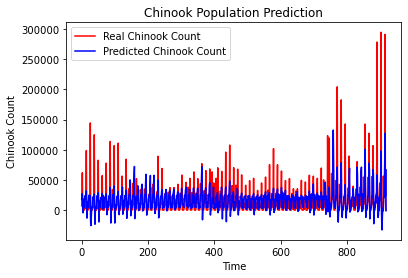

The root mean squared error is 22569.371440276114.


In [197]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

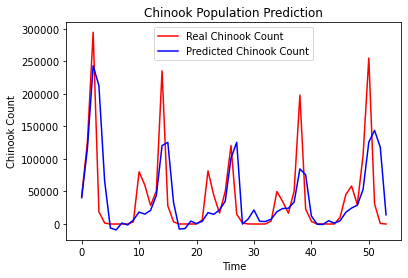

The root mean squared error is 54056.511394720605.


In [198]:
plot_predictions(y_test, test_preds_LSTM)
return_rmse(y_test, test_preds_LSTM)

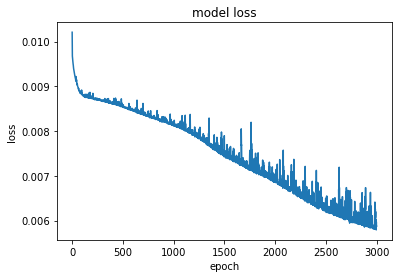

In [199]:
plot_loss(history_LSTM)

In [200]:
# global var for baseline
y_test_year = month_to_year(y_test)
len(y_test)
len(y_test_year)

49


4

In [201]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)
y_test_year = y_test_year.astype(np.int64)
print(y_test_year)
# print(GRU_test_year)

49
    Count
0  498710
1  439060
2  294840
3  347600
    Count
0  488943
1  336031
2  381766
3  535809


In [205]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = month_to_year(test_preds_LSTM)
LSTM_test_year = LSTM_test_year.astype(np.int64)

49


In [206]:
LSTM_test_year

,Count
0,368223
1,309834
2,318090
3,522385


In [203]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 69810.9781831478.
